## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

#### Prepare English dictionary for language detection

In [5]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [7]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [8]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 75% English words
#### Also, make the mentions of usernames and URLs generic

In [9]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             t["tweet_data"]["full_text"]))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [10]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [11]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [12]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

In [13]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

#### Show examples

In [14]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
I don't trust people that pronounce milk "melk."


In [15]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Hearing rumors about #Blackfish Katina being seriously injured ➋; something regarding a badly damaged dorsal fin with other injuries. Not confirmed. Reportedly pulled from shows. KAT is likely a former Icelandic podmate of #Kasatka, who was euthanized last year by SW ➊


#### Find the length of the smaller dataset

In [16]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [17]:
subtweets_data = sample(subtweets_data, smallest_length)

In [18]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [19]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11285


#### Prepare data for training

In [20]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [21]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [22]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames and URLs, as well as common English first names

In [23]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [24]:
generic_tokens = {"➊", "➋"}

In [25]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [26]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [27]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [28]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.6951    0.6197    0.6552      1078
    subtweet     0.6836    0.7515    0.7160      1179

 avg / total     0.6891    0.6885    0.6870      2257

Test Data Accuracy: 0.6885

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9848    0.9791    0.9820     10207
    subtweet     0.9790    0.9848    0.9819     10106

 avg / total     0.9819    0.9819    0.9819     20313

Train Data Accuracy: 0.9819

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7310    0.6308    0.6772      1116
    subtweet     0.6816    0.7730    0.7244      1141

 avg / total     0.7061    0.7027    0.7011      2257

Test Data Accuracy: 0.7027

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9862    0.9781    0.9821     10169
    subtweet     0.9782    0.9863    0.9822     10144



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [29]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [30]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 2.44 s, sys: 66.8 ms, total: 2.51 s
Wall time: 2.79 s


In [31]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [32]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [33]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(25)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #absapremiership,-12.9930,.,-7.5396
1,! ! #agentsofshield,-12.9930,",",-7.9076
2,! ! #cholecystectomy,-12.9930,"""",-8.0629
3,! ! #dwts26,-12.9930,people,-8.3524
4,! ! #fbr,-12.9930,?,-8.4233
5,! ! #goblue,-12.9930,like,-8.5782
6,! ! #happyeasterfromhell,-12.9930,don't,-8.5917
7,! ! #ipl2018,-12.9930,just,-8.6237
8,! ! #keepittight,-12.9930,i'm,-8.7079
9,! ! #manila,-12.9930,!,-8.7251


#### Define function for visualizing confusion matrices

In [34]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

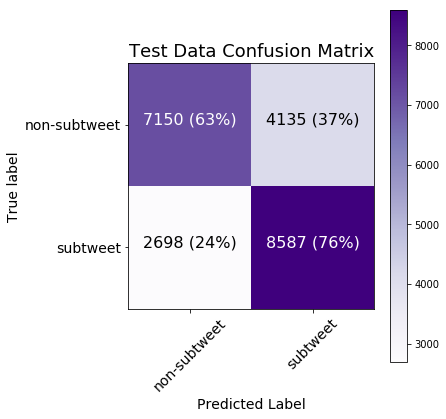

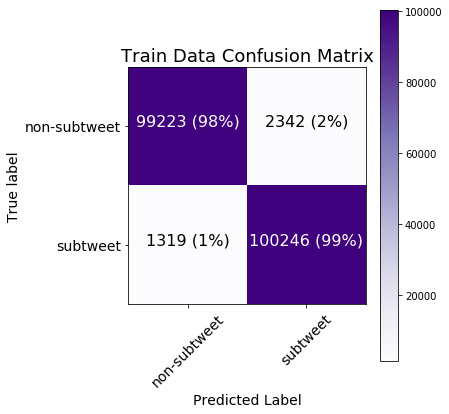

In [35]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [36]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [37]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [38]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [39]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [40]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 8.95 s, sys: 118 ms, total: 9.06 s
Wall time: 9.21 s


#### Show a random table

In [41]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
751,I think u and I both know that we're both annoying bc we complain way too much,2018-01-11 15:01:50,1,0,951544701798305792,0.8675
886,angery tweets targeted at a specific person or group of people without directly mentioning the target,2017-12-27 18:08:54,2,0,946155959679967234,0.8605
682,Shout out to ➌ for liking pretty much any tweet I make,2018-01-16 03:01:11,1,0,953175283909218304,0.8555
1236,➌ i dont rly wanna die yet can u cool down,2017-10-17 14:10:00,0,0,920351202931625986,0.8406
803,the fact that twitter shows tweets people you follow have liked means that sub-liking is also a thing,2018-01-10 16:56:58,6,0,951211288046301184,0.8377


#### Prepare statistics on tweets

In [42]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [43]:
test_df_stats = tests_df.describe()

In [44]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [45]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5259,0.5246,0.5590,0.5295,0.5274,0.5071,0.4465,0.5445,0.5254,0.4531,0.5449,0.5149,0.5497,0.5479
std,0.1112,0.1186,0.1197,0.1158,0.1082,0.1153,0.1021,0.1221,0.1136,0.1005,0.1220,0.1192,0.1224,0.1108
min,0.2466,0.1192,0.1627,0.1548,0.1416,0.0827,0.1400,0.1732,0.1554,0.1650,0.0925,0.0738,0.1736,0.1092
25%,0.4529,0.4458,0.4750,0.4535,0.4530,0.4349,0.3778,0.4673,0.4506,0.3828,0.4710,0.4357,0.4724,0.4834
50%,0.5242,0.5196,0.5570,0.5273,0.5268,0.5002,0.4471,0.5403,0.5220,0.4576,0.5446,0.5104,0.5501,0.5492
75%,0.5985,0.6026,0.6410,0.6093,0.5978,0.5794,0.5089,0.6277,0.5977,0.5151,0.6275,0.5925,0.6312,0.6241
max,0.8844,0.8968,0.8744,0.9074,0.9136,0.8984,0.7942,0.8792,0.9068,0.7890,0.8558,0.8919,0.8540,0.8675


#### Plot a histogram with three random users

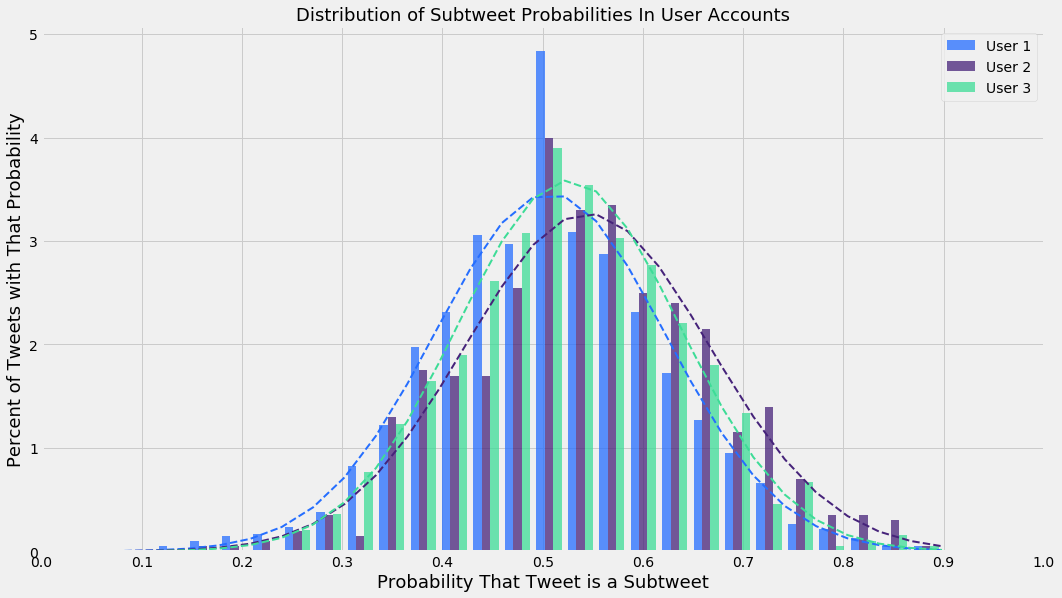

In [46]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [47]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [48]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5238
std,0.1173
min,0.0738
25%,0.4460
50%,0.5201
75%,0.6005
max,0.9136


#### Now plot

No handles with labels found to put in legend.


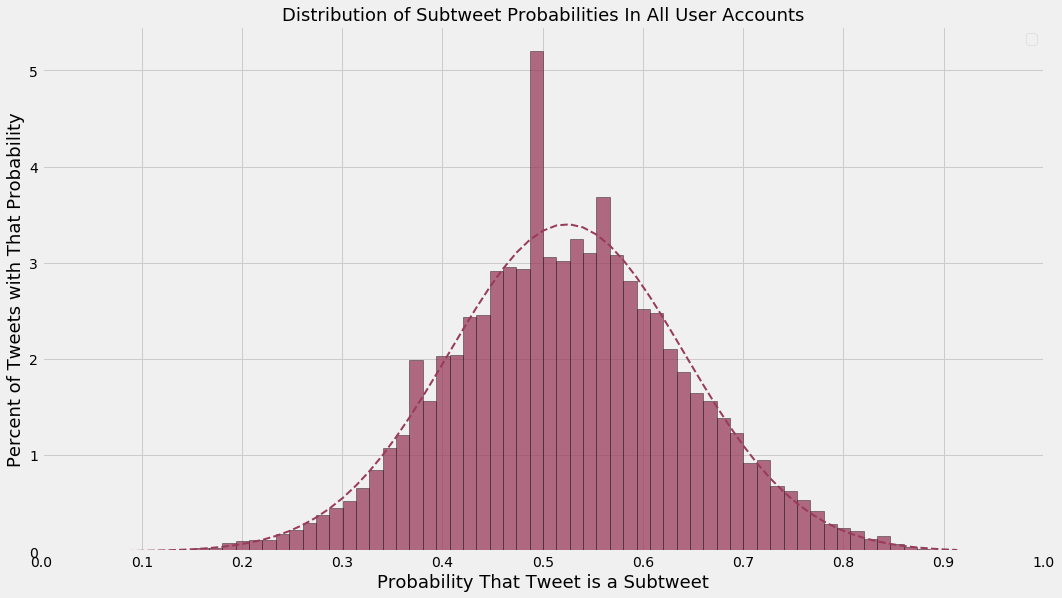

In [49]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [50]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")) for tweet in training_data]

#### Lengths

In [51]:
length_data = [len(tweet) for tweet in training_data]

In [52]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [53]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [54]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [55]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [56]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
67,281,"""Cheatin' Obama""—a President who, in eight years, had no major scandals, no administration officials indicted, no personal embarrassments (porn star-related or otherwise), & all while being subjected to more scrutiny and a higher standard than any of his predecessors.\n\nOkay then."
1768,281,"I was just on KFAN talking about, among many other things, Twins games being canceled by snow and how extreme weather across the country has caused other MLB teams to cancel games as well. By the time I got to my car to drive home from the station, this e-mail was waiting for me."
13881,281,"I can't believe that one of my favorite series ever ""Adventure Time"" is about to end after an eight year adventure. Even though i really don't want to see it end I'm happy at the way the creators have made the final few episodes & can't wait to see the Final! ""Come along with me"""
6836,281,"ok so im part of several astro facebook groups as yall know and we all just made our versions of this alignment chart for the signs, here's mine and the blank copy reply with urs!!!! this is 100% for fun and i don't think any signs or placements are actually cursed or blessed etc"
21867,281,"Some people are undecided about testing on animals. Understandable. There's so much propaganda and secrecy about it. Here's a quick test though, & you're answer should tell you. What would you do if some man came to your house & squirted disinfectant in your beautiful dog's eyes?"


#### Top 5 shortest tweets

In [57]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
10231,4,Rude
3054,4,Ugly
21197,4,fear
6622,4,Lame
7643,4,soft


#### Tweet length statistics

In [58]:
length_data_for_stats.describe()

,Length
count,22570.0000
mean,103.9976
std,73.3684
min,4.0000
25%,46.0000
50%,84.0000
75%,145.0000
max,281.0000


#### Punctuation

In [59]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [60]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [61]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
6564,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
18521,10,"Billboard Hot 100: #62(-3) Tell Me You Love Me, [19 weeks]. *peak: #53*"
15173,9,"#Cubs Prospect Thread: Dillon Maples - 2011 (14th)\n\n100 K/38 BB, 45 H, in 63.1 IP between A+/AA/AAA\n\nFormer top prospect considered retirement last offseason. But instead Maples developed a hard slider, embraced pitching backwards, and flew through 3 levels before making majors."
2674,9,"Old, out-of-touch nominally liberal guy: ""Well, some of you won't appreciate my courage, but I've got some hard truths to share!""\n\n*Nazis and predators praise him*\n\n""See? This shows that I am wise and insightful."""
15765,9,"**Bot Alert** #Resistance\n1/ Tuesday (4/10) List 2\n*Warning: Adult Content *Warning: Don't click the links in the accounts\nYes, it's THAT group ... I am still finding them easily. Heaven only knows how many there actually are ...."


#### Tweets punctuation statistics

In [62]:
punctuation_data_for_stats.describe()

,Punctuation
count,22570.0000
mean,1.9776
std,1.6243
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [63]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [64]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [65]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,That's just the risk you run with playing sports and if you don't like I️t then choose something safer 🤔
12887,8,"""My little loser."" Only Roseanne could make that sound sweet. \n#Roseanne"
12863,8,"Upset or saddened by a good player leaving is completely different than being disrespectful or offensive to those players, which you and a number of other fans have been. You should be ashamed of the things you've said to and about athletes and coaches in recent months."
12864,8,"About to start Cap America Civil War in prep for #infintywar \n\nI swear if Iron Man dies, this will be me for a week. Maybe longer."
12866,8,"Y'all better watch out, my girl has been on her shit! Idek how to prepare y'all, but just be ready (if you can be). 😩😩😩"


#### Top 5 tweets with fewest stop words

In [66]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
14360,0,When
4627,0,luv u
20561,0,well .... fuck
4917,0,𝓸𝓵𝓲𝓿𝓲𝓪'𝓼 𝕣𝕒𝕟𝕕𝕠𝕞 𝙦𝙪𝙚𝙨𝙩𝙞𝙤𝙣 𝙩𝙝𝙧𝙚𝙖𝙙.
348,0,Fuck...


#### Tweets stop words statistics

In [67]:
stop_words_data_for_stats.describe()

,Stop words
count,22570.0000
mean,7.1026
std,1.3490
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [68]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [69]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [70]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [71]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [72]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
3930,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
16589,"-Many👮‍♂️suffer in silence, not always by choice but by design! #PTSD can be a career killer & worse many PD's DO NOT see P.T.S.D as an insured disability; This has to change🆘- Hiding mine for 3 years made my #Fight unbearable!\n\nPlease help us #UnmaskPTSD & #SaveOurLives ⚖️",58
12360,"If you live in Arizona, tell me everything good about it... Please and thank you 😁👌🏽\n\nAlso does anybody know any wavy ass barbershops or dope tattoo artists or ppl who are just nice kuz we wanna make friends out here tbh. I want a basic ""how to"" of AZ so teach me shit.",57
4912,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57
471,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",57


#### Top 5 tweets with fewest unique words

In [73]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
6622,Lame,1
19846,Same same,1
12414,mood,1
3307,Drive Drive Drive Drive Drive,1
17777,scReeCH,1


#### Tweets unique words statistics

In [74]:
unique_words_data_for_stats.describe()

,Unique words
count,22570.0000
mean,18.6724
std,11.8524
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

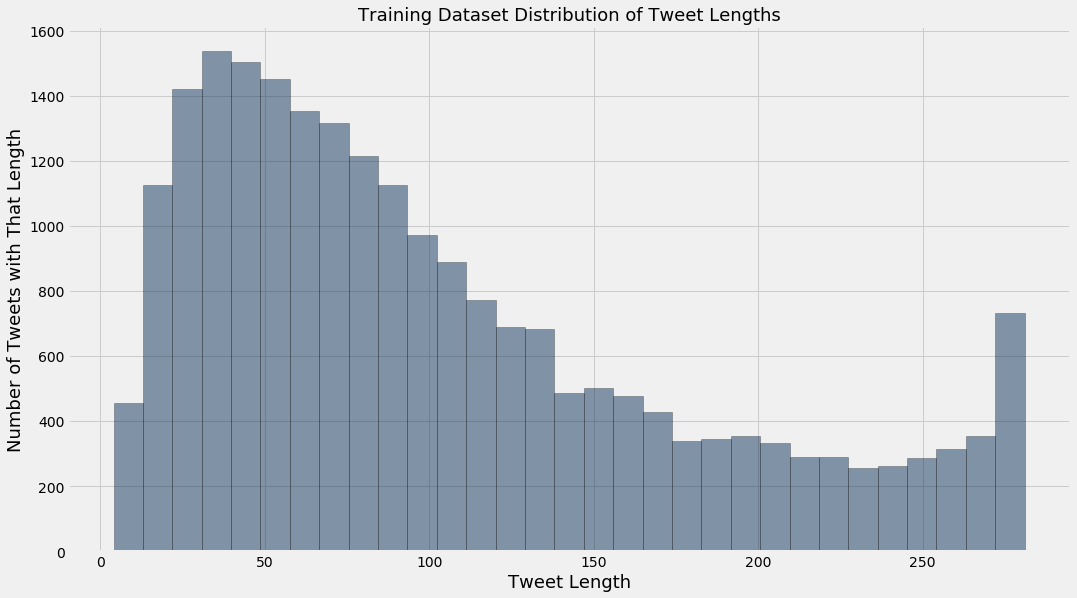

In [75]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

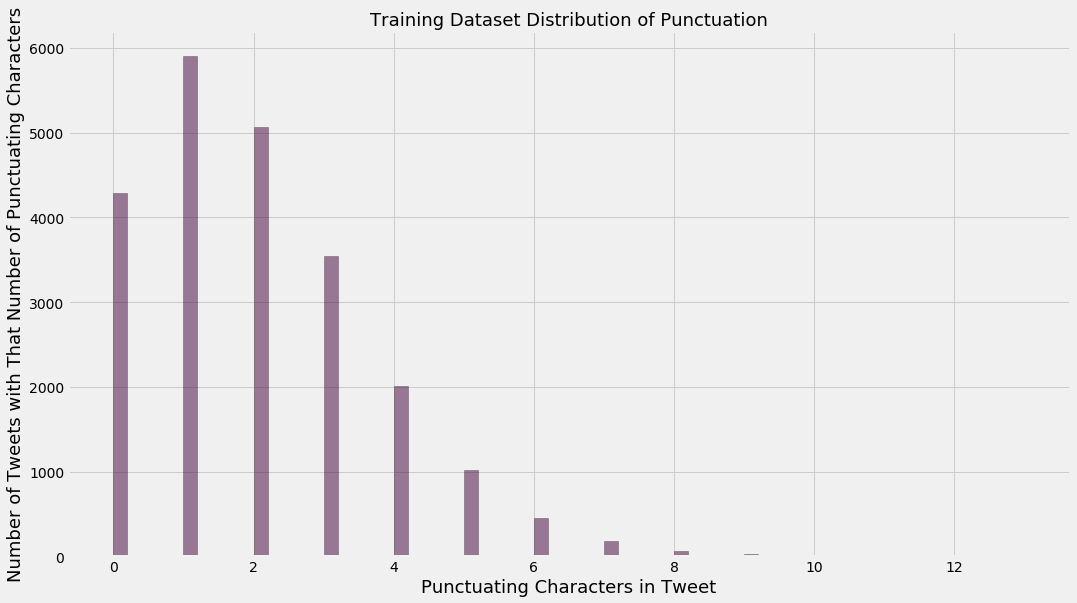

In [76]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

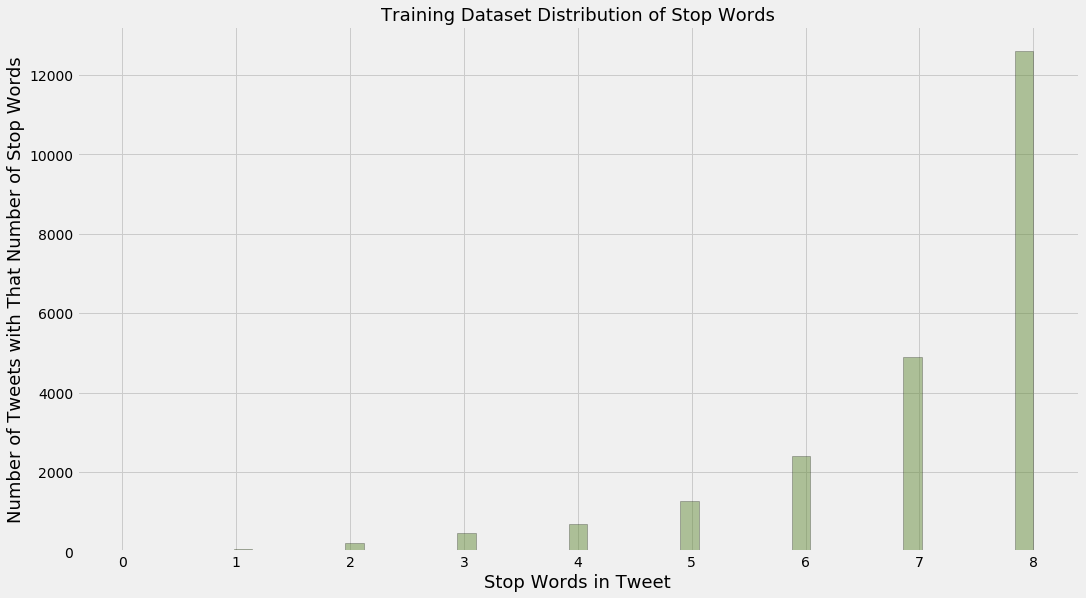

In [77]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

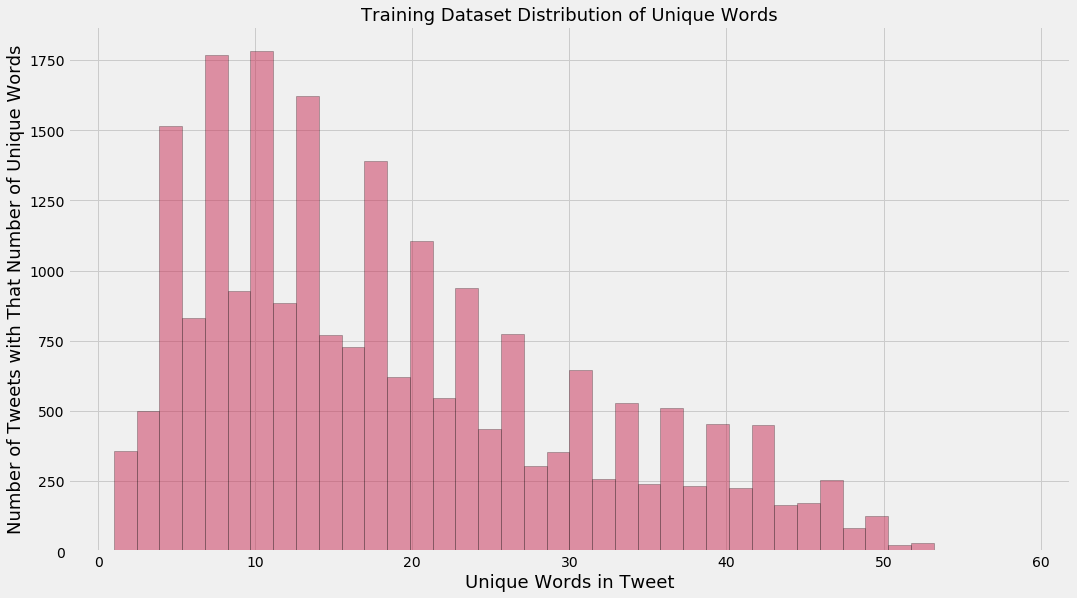

In [78]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()